In [120]:
import torchaudio
import numpy as np
from torch import Tensor
from IPython.display import Audio
from scipy.signal import find_peaks
from matplotlib import pyplot as plt
from helpers.path_utils import get_base_dir
from helpers.transform import TrimAfterTrigger, min_max_scale
from helpers.plot import plot_wavelet_spectrogram, plot_audio_fft

In [121]:
AUDIO_NAME = "SAM-Third Heart Sound.wav"
audio_dir = get_base_dir().joinpath("data", "mobile", "SAM", AUDIO_NAME)

audio, sample_rate = torchaudio.load(str(audio_dir))
print("Sample rate: ", sample_rate)

Sample rate:  22050


Sample rate:  4000


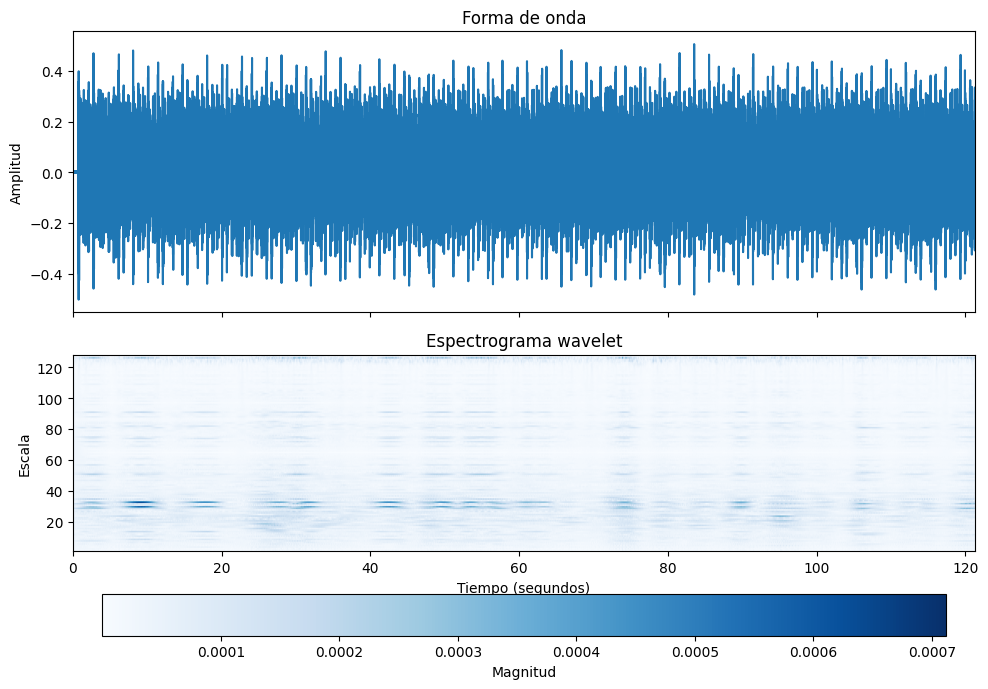

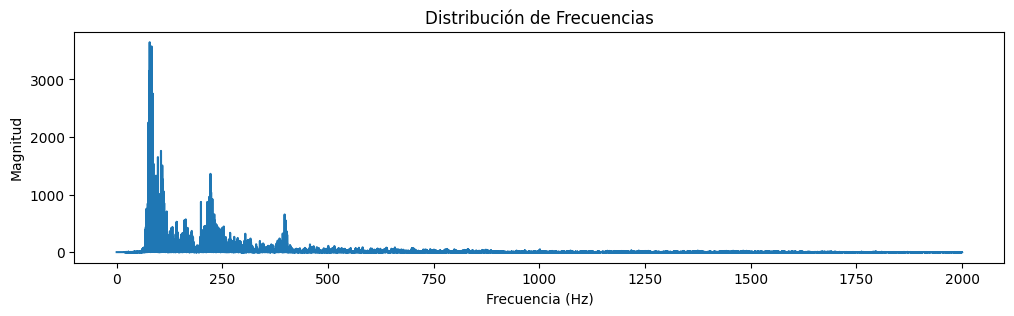

In [122]:
new_sample_rate = 4000

resampler = torchaudio.transforms.Resample(
    orig_freq=sample_rate, new_freq=new_sample_rate
)

audio = resampler(audio)
sample_rate = new_sample_rate

print("Sample rate: ", sample_rate)

plot_wavelet_spectrogram(audio.numpy(), sample_rate)  # , downsample_factor=1)
plot_audio_fft(audio.numpy(), sample_rate)

Audio(audio, rate=sample_rate, autoplay=True)

# Snippet to detect hearbeats

In [123]:
SNIPPET_STARTS = 0
SNIPPET_ENDS = 4

cut_starts = int(SNIPPET_STARTS * sample_rate)
cut_ends = int(SNIPPET_ENDS * sample_rate)

snippet = audio[:, cut_starts:cut_ends].clone()
audio.shape, snippet.shape

(torch.Size([1, 485200]), torch.Size([1, 16000]))

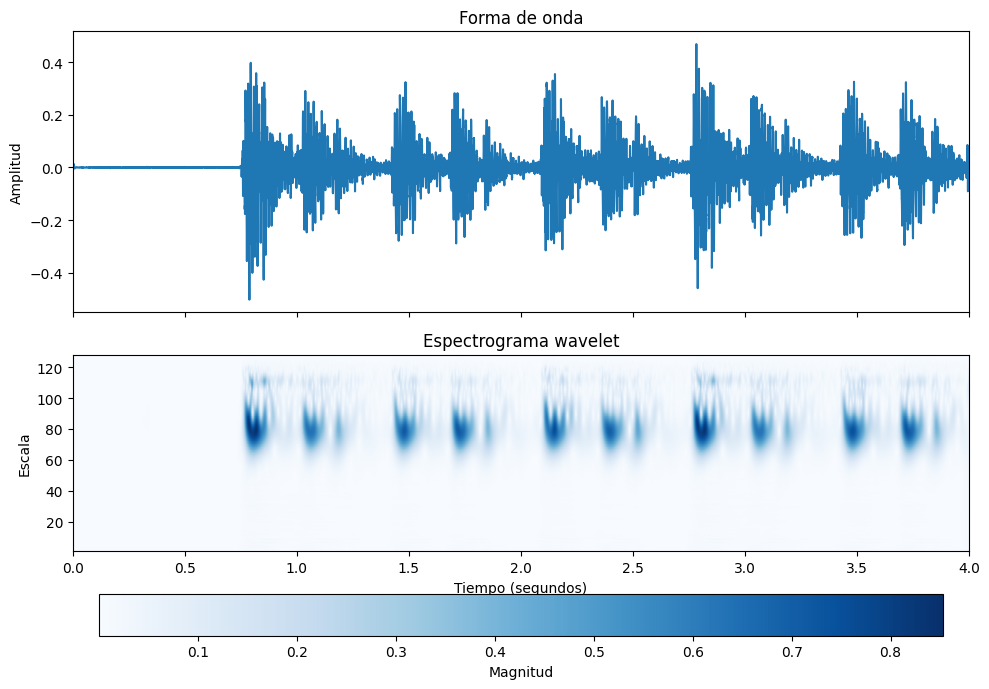

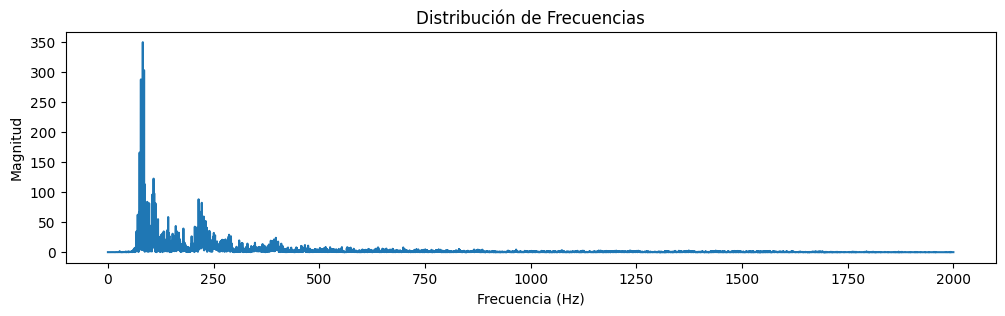

In [124]:
plot_wavelet_spectrogram(snippet, sample_rate, downsample_factor=1)
plot_audio_fft(snippet.numpy(), sample_rate)

Audio(snippet, rate=sample_rate, autoplay=True)

# TrimAfterTrigger class
We can use some methods of that class to detect heartbeats

In [125]:
tat = TrimAfterTrigger()
tat

In [126]:
from helpers.transform import apply_bandpass_filter

snippet = apply_bandpass_filter(snippet, sample_rate, low_freq=0, high_freq=100)

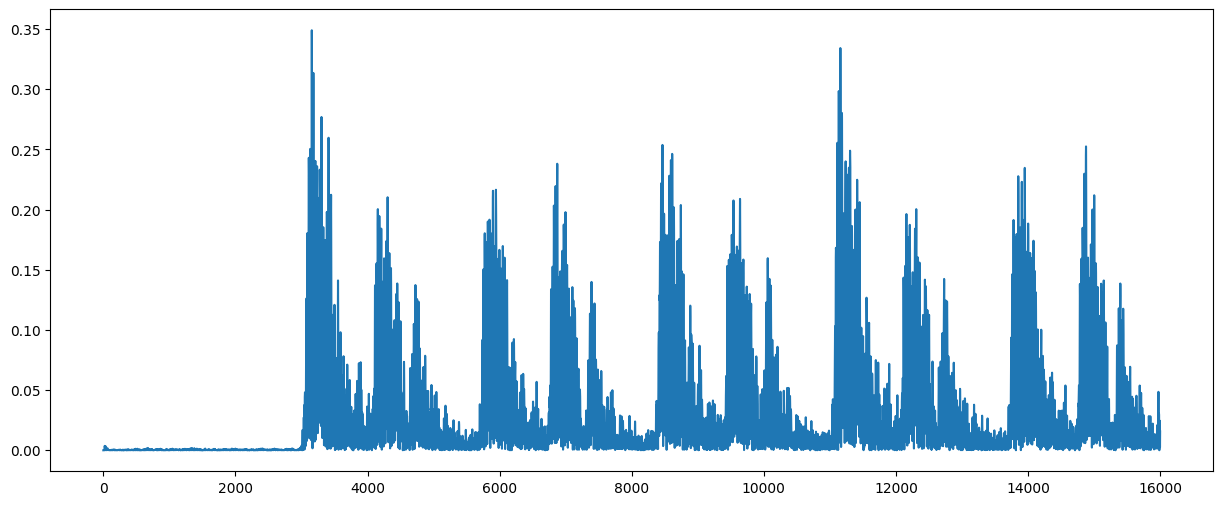

In [127]:
abs_snippet = tat.audio_to_abs(snippet)
plt.figure(figsize=(15, 6))
plt.plot(abs_snippet.squeeze())

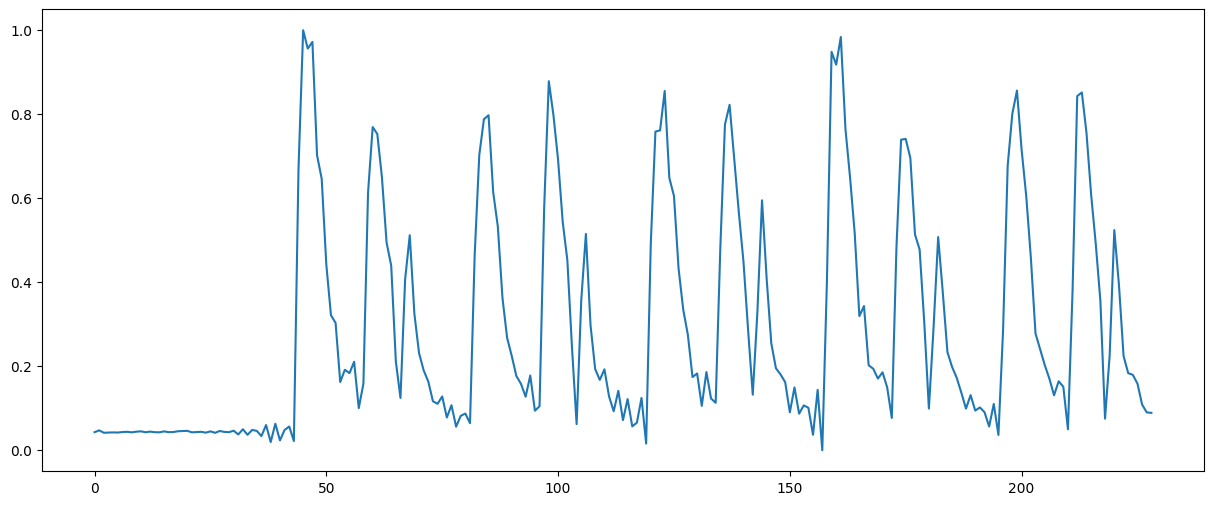

In [128]:
DOWNSAMPLE_FACTOR = 70
downsampled = tat.downsample_audio(abs_snippet, DOWNSAMPLE_FACTOR).copy()
scaled = tat.scale_audio(Tensor(downsampled), scaler=min_max_scale).squeeze()

plt.figure(figsize=(15, 6))
plt.plot(scaled.squeeze())

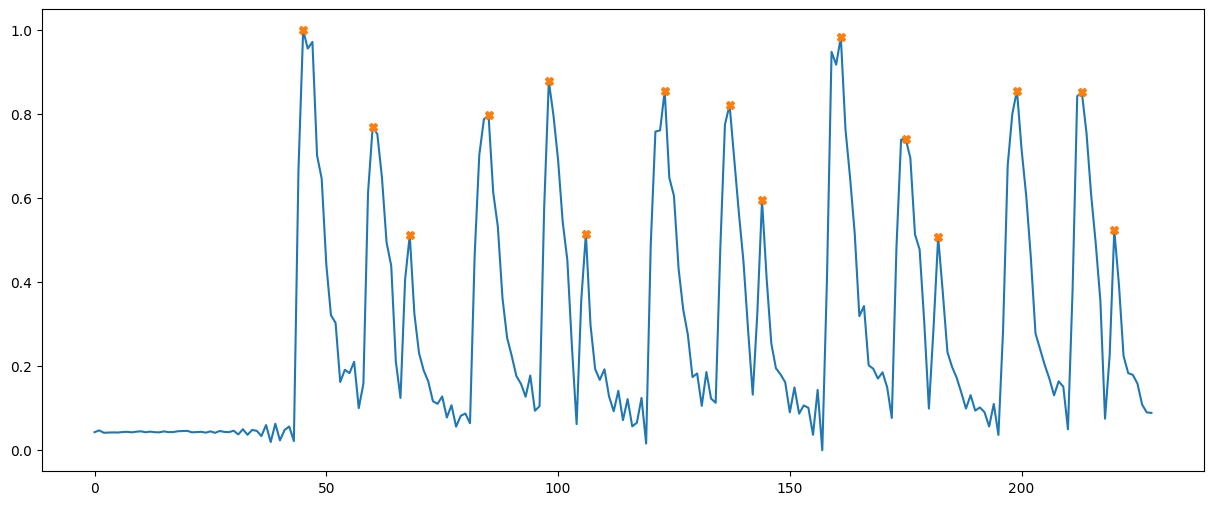

In [129]:
PEAKS_HEIGHT = np.percentile(scaled, 60)
PEAKS_PROMINENCE = 0.15

peaks, _ = find_peaks(scaled, height=PEAKS_HEIGHT, prominence=PEAKS_PROMINENCE)

plt.figure(figsize=(15, 6))
plt.plot(scaled)
plt.plot(peaks, scaled[peaks], "X")

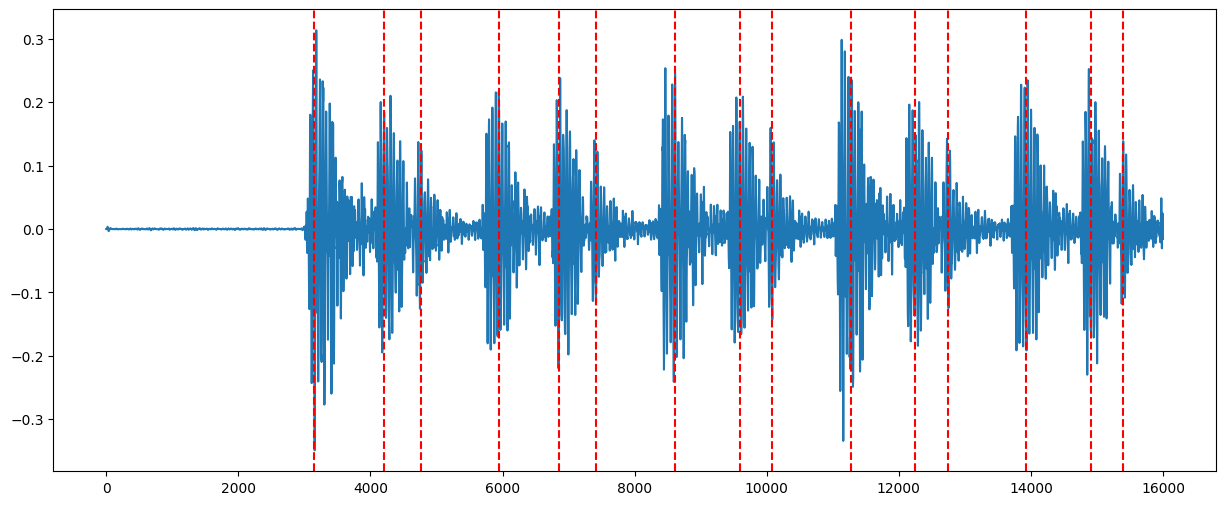

Peaks found in downsampled signal: [ 45  60  68  85  98 106 123 137 144 161 175 182 199 213 220]
Peaks in real signal: [ 3150  4200  4760  5950  6860  7420  8610  9590 10080 11270 12250 12740
 13930 14910 15400]
Difference between each: [1050  560 1190  910  560 1190  980  490 1190  980  490 1190  980  490]


In [130]:
upsampled_peaks = peaks * DOWNSAMPLE_FACTOR

plt.figure(figsize=(15, 6))
plt.plot(snippet.squeeze())

for peak in upsampled_peaks:
    plt.axvline(x=peak, color="red", linestyle="--")

plt.show()

print(f"Peaks found in downsampled signal: {peaks}")
print(f"Peaks in real signal: {upsampled_peaks}")
print(f"Difference between each: {np.diff(upsampled_peaks)}")

In [131]:
import numpy as np

# Dos arrays de ejemplo
array1 = np.array([1, 2, 3])  # Array más pequeño
array2 = np.array([0, 1, 2, 3, 4, 5])  # Array más grande


# Función para comparar el array pequeño con segmentos del array grande
def mover_y_diferencia_cero(arr_small, arr_large):
    len_small = len(arr_small)
    len_large = len(arr_large)

    # Si el array pequeño es mayor que el grande, no se puede hacer
    if len_small > len_large:
        print("El array pequeño no puede ser mayor que el grande.")
        return -1

    # Deslizar el array pequeño sobre el grande
    for i in range(len_large - len_small + 1):
        # Tomar un segmento del array grande del mismo tamaño que el pequeño
        segmento = arr_large[i : i + len_small]

        # Calcular la diferencia
        diferencia = segmento - arr_small
        print(f"Diferencia en posición {i}: {diferencia}")

        # Si todas las diferencias son 0, terminar
        if np.all(diferencia == 0):
            print(f"Las arrays coinciden con un desplazamiento de {i} pasos.")
            return i

    print("No se encontró coincidencia.")
    return -1


# Llamada a la función
mover_y_diferencia_cero(array1, array2)

Diferencia en posición 0: [-1 -1 -1]
Diferencia en posición 1: [0 0 0]
Las arrays coinciden con un desplazamiento de 1 pasos.


1